<a href="https://colab.research.google.com/github/MeikoFudo/DLS_olympiad/blob/main/dls_olympiad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("yes" if torch.cuda.is_available() else "no")

yes


In [5]:
train_data = pd.read_csv("fake_or_real_train.csv", index_col="id")
test_data = pd.read_csv("fake_or_real_test.csv", index_col="id")

In [8]:
train_data.head()

,text,label
id,,
0,"Фантастический боевик о супергероях, сражающих...",1
1,Мажор виртуозно сбегает из тюрьмы и начинает н...,0
2,"Затерянный мир — это фантастический боевик, ко...",1
3,"Загадочная девушка, после автомобильной аварии...",0
4,"Это история о двух друзьях, которые решили отп...",1


In [9]:
print("fake")
train_data.iloc[0]["text"]

fake


'Фантастический боевик о супергероях, сражающихся со злом'

In [56]:
print("real")
train_data.iloc[1]["text"]

real


'Мажор виртуозно сбегает из тюрьмы и начинает новую жизнь. Новую сладкую жизнь! Соколовский вливается в светскую тусовку, где все сидят на новом синтетическом наркотике, и его снова окружают тачки, виллы и топ-модели. Друзья, враги и ФСБ идут по следу Мажора, пытаясь понять, какую игру он затеял и на чьей он стороне. Игорь же пытается понять, кто он сам — предатель, святой или всё тот же… Мажор?'

In [57]:
train_data["label"].value_counts(normalize=True)

,proportion
label,
1,0.579501
0,0.420499


In [58]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1805 entries, 0 to 1804
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1801 non-null   object
 1   label   1805 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 42.3+ KB


In [10]:
train_data[train_data["text"].isnull()]

,text,label
id,,
331,NaN,0
495,NaN,0
1160,NaN,0
1401,NaN,0


In [6]:
train_data = train_data.dropna()
test_data = test_data.dropna()

In [7]:
X_train = train_data["text"]
y_train = train_data["label"]
X_test = test_data["text"]

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)
X_train.shape

(1440,)

<Axes: >

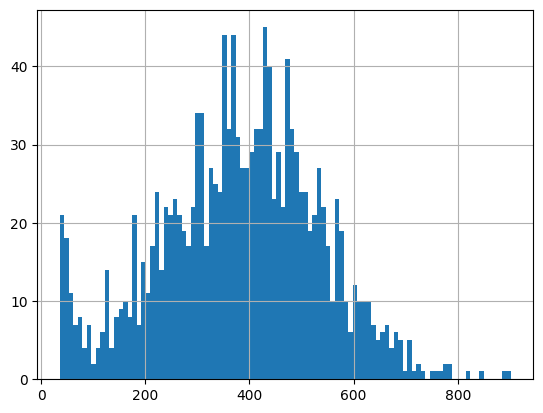

In [14]:
X_train.str.len().hist(bins=100)

In [13]:
pd.cut(X_train.str.len(), bins=10).value_counts()

,count
text,
"(295.8, 382.4]",312
"(382.4, 469.0]",311
"(469.0, 555.6]",251
"(209.2, 295.8]",200
"(555.6, 642.2]",117
"(122.6, 209.2]",107
"(35.134, 122.6]",88
"(642.2, 728.8]",42
"(728.8, 815.4]",8


<Axes: >

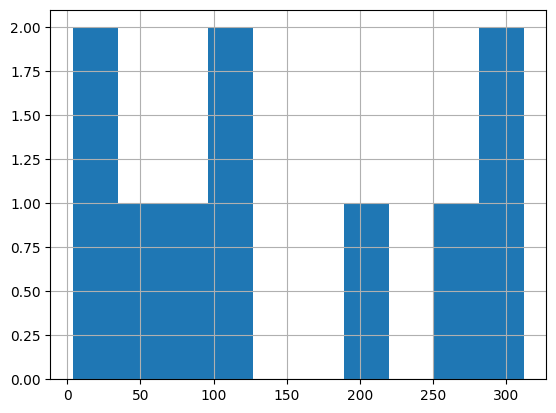

In [14]:
pd.cut(X_train.str.len(), bins=10).value_counts().hist()

## TF-IDF + Random Forest

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(X_train).toarray()
X_val = vectorizer.transform(X_val).toarray()
X_test = vectorizer.transform(X_test).toarray()

In [16]:
X_train.shape

(1440, 10000)

In [17]:
X_train[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [18]:
pd.DataFrame(X_train[0]).value_counts()

,count
0,
0.000000,9971
0.253907,2
0.182003,2
0.090011,1
0.262409,1
0.246960,1
0.241086,1
0.231510,1
0.223864,1


In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [23]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [25]:
val_predictions = model.predict(X_val)
accuracy_score(y_val, val_predictions)

0.9584487534626038

In [26]:
val_predictions_proba = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, val_predictions_proba)

0.9955996131528047

In [4]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.8 MB/s eta 0:00:00


## Word2Vec + CatBoostClassifier

In [15]:
import gensim
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [16]:
X_train_split = [sentence.split() for sentence in X_train]
X_val_split = [sentence.split() for sentence in X_val]

In [17]:
X_train_split

[['Действие',
  'происходит',
  'в',
  'далеком',
  'будущем,',
  'где',
  'человечество',
  'столкнулось',
  'с',
  'новой',
  'угрозой',
  '—',
  'инопланетным',
  'вторжением.',
  'Главный',
  'герой,',
  'бывший',
  'солдат,',
  'должен',
  'собрать',
  'команду',
  'из',
  'разных',
  'людей',
  'и',
  'объединить',
  'их',
  'усилия,',
  'чтобы',
  'спасти',
  'планету',
  'от',
  'уничтожения.'],
 ['Трогательная', 'драма', 'об', 'одиночестве', 'в', 'большом', 'городе'],
 ['Путешествие',
  'в',
  'прошлое',
  '—',
  'это',
  'приключенческий',
  'фильм',
  'о',
  'том,',
  'как',
  'главный',
  'герой',
  'случайно',
  'попадает',
  'в',
  'прошлое',
  'и',
  'меняет',
  'ход',
  'истории.',
  'Его',
  'цель',
  '—',
  'исправить',
  'ошибки',
  'прошлого',
  'и',
  'предотвратить',
  'катастрофу,',
  'которая',
  'может',
  'уничтожить',
  'весь',
  'мир.',
  'Ему',
  'предстоит',
  'столкнуться',
  'с',
  'множеством',
  'препятствий',
  'и',
  'опасностей,',
  'а',
  'также',


In [18]:
word2vec_model = gensim.models.Word2Vec(
    sentences=X_train_split, vector_size=500, window=10, min_count=1, workers=4
)

In [19]:
def vectorize_text(text_data, word2vec_model):
    vectors = []
    for sentence in text_data:
        tmp = [ word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv ]
        vector = np.mean(tmp, axis=0)
        vectors.append(vector)
    # print(tmp)
    return np.array(vectors)

In [20]:
X_train_w2v = vectorize_text(X_train_split, word2vec_model)
X_val_w2v = vectorize_text(X_val_split, word2vec_model)

In [21]:
X_train_w2v.shape

(1440, 500)

In [22]:
catboost = CatBoostClassifier(iterations=700, eval_metric='Accuracy')
catboost.fit(X_train_w2v, y_train, eval_set=(X_val_w2v, y_val))

Learning rate set to 0.040496
0:	learn: 0.8715278	test: 0.6952909	best: 0.6952909 (0)	total: 231ms	remaining: 2m 41s
1:	learn: 0.8729167	test: 0.7036011	best: 0.7036011 (1)	total: 349ms	remaining: 2m 1s
2:	learn: 0.8659722	test: 0.6980609	best: 0.7036011 (1)	total: 482ms	remaining: 1m 51s
3:	learn: 0.8673611	test: 0.6426593	best: 0.7036011 (1)	total: 607ms	remaining: 1m 45s
4:	learn: 0.8687500	test: 0.6454294	best: 0.7036011 (1)	total: 746ms	remaining: 1m 43s
5:	learn: 0.8715278	test: 0.6648199	best: 0.7036011 (1)	total: 873ms	remaining: 1m 40s
6:	learn: 0.8659722	test: 0.6454294	best: 0.7036011 (1)	total: 1.01s	remaining: 1m 40s
7:	learn: 0.8673611	test: 0.6703601	best: 0.7036011 (1)	total: 1.13s	remaining: 1m 38s
8:	learn: 0.8694444	test: 0.6703601	best: 0.7036011 (1)	total: 1.26s	remaining: 1m 36s
9:	learn: 0.8701389	test: 0.6731302	best: 0.7036011 (1)	total: 1.39s	remaining: 1m 36s
10:	learn: 0.8715278	test: 0.6648199	best: 0.7036011 (1)	total: 1.6s	remaining: 1m 40s
11:	learn: 0.8

In [23]:
accuracy_score(y_val, catboost.predict(X_val_w2v))

0.8282548476454293

In [24]:
roc_auc_score(y_val, catboost.predict_proba(X_val_w2v)[:, 1])

0.8854287556415216

## Bert

In [9]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00


In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [11]:
import torch
from datasets import Dataset

In [12]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y_train)))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

In [14]:
train_texts = [{"text": t} for t in X_train]
val_texts = [{"text": t} for t in X_val]

In [15]:
train_dataset = Dataset.from_dict({'text': X_train, 'labels': y_train})
val_dataset = Dataset.from_dict({'text': X_val, 'labels': y_val})

In [16]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

Map:   0%|          | 0/361 [00:00<?, ? examples/s]

In [17]:
len(next(iter(train_dataset))['input_ids'])

512

In [18]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [19]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [30]:
trainer = Trainer(
    model=model.to("cuda"),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,No log,0.415980,0.930748,0.930653,0.930748
2,No log,0.349586,0.936288,0.939627,0.936288
3,0.150900,0.434846,0.936288,0.937124,0.936288


TrainOutput(global_step=540, training_loss=0.14468506088963262, metrics={'train_runtime': 483.3315, 'train_samples_per_second': 8.938, 'train_steps_per_second': 1.117, 'total_flos': 1136639759155200.0, 'train_loss': 0.14468506088963262, 'epoch': 3.0})

In [31]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }

In [32]:
eval_results = trainer.evaluate()

print("Accuracy:", eval_results['eval_accuracy'])
print("Precision:", eval_results['eval_precision'])
print("Recall:", eval_results['eval_recall'])

Accuracy: 0.9362880886426593
Precision: 0.9371241869856829
Recall: 0.9362880886426593
